In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib
import dataset.dataset
import dataset.loader
importlib.reload(dataset.dataset)
importlib.reload(dataset.loader)

from dataset.dataset import get_test_datasets, get_validation_datasets, get_dataset_shapes
from network import vlayers
from network import vlayers_conv
importlib.reload(vlayers)
importlib.reload(vlayers_conv)
pass

In [2]:
test = tf.constant([[0, 1,1,0], [0,1,1,0]])
tf.concat([test, [[0], [0]]], axis=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[0, 1, 1, 0, 0],
       [0, 1, 1, 0, 0]])>

In [3]:
# K-fold validation of model
def validate_model(model, datasets_generator):
    history1_sum = np.single(0)
    history2_sum = np.single(0)
    k = 0
    for train_dataset, validation_dataset in datasets_generator:
        history = model.fit(
            train_dataset,
            epochs=2,
            validation_data=validation_dataset,
            verbose=0,
            use_multiprocessing = True
        )
        history1_sum += np.array(history.history['mean_squared_error'], dtype=np.float64)
        history2_sum += np.array(history.history['val_mean_squared_error'], dtype=np.float64)
        k += 1
    
    history1_avr = history1_sum / k
    history2_avr = history2_sum / k
    
    x = range(1, len(history1_avr)+1)
    plt.plot(x, history1_avr, 'b')
    plt.plot(x, history2_avr, 'r--')
    plt.legend(['loss', 'validation'])
    plt.show() 

# Testing of model
def test_model(model, train_dataset, test_dataset):
    history = model.fit(
        train_dataset,
        epochs=2,
        validation_data=test_dataset,
        verbose=0,
        use_multiprocessing = True
    )
    # Visualize validation error
    y1 = history.history['mean_squared_error']
    y2 = history.history['val_mean_squared_error']
    x = range(1, len(y1)+1)
    plt.plot(x, y1, 'b')
    plt.plot(x, y2, 'r--')
    plt.legend(['loss', 'validation'])
    plt.show() 

In [9]:
# Create models

def get_keras_model(dataset_shapes):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = layers.Conv2D(5, 5, 
                      activation='relu', 
                      strides=(1,1), 
                      padding='valid', 
                      kernel_initializer='random_normal', 
                      bias_initializer='random_normal'
                     )(inputs)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(4,4), strides=(4,4), padding='valid')(x)
    x = layers.Conv2D(8, 5, 
                      activation='relu', 
                      strides=(1,1), 
                      padding='valid', 
                      kernel_initializer='random_normal', 
                      bias_initializer='random_normal'
                     )(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(10, 2, 
                      activation='relu', 
                      strides=(1,1), 
                      padding='valid', 
                      kernel_initializer='random_normal', 
                      bias_initializer='random_normal'
                     )(x)
    x = layers.Activation('sigmoid')(x)
    outputs = layers.Flatten()(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model
                    
def get_simple_vector_model(dataset_shapes):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = vlayers_conv.VInputConv((5,5), 
                      num_filters=5, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid'
                     )(inputs)
    x = vlayers_conv.VConv((4,4), 
                      kernel_type="padding",
                      strides=(4,4), 
                      padding_type='valid',
                      layer_type="convolution",
                      activation="relu"
                     )(x)
    x = vlayers_conv.VConv((5,5), 
                      num_filters=8, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid',
                      layer_type="pading",
                      pooling="max"
                     )(x)
    x = vlayers_conv.VConv((2,2), 
                      num_filters=10, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid',
                      layer_type="convolution",
                      activation="relu"
                     )(x)
    x = vlayers_conv.VOutputConv(layer_type="convolution", activation="relu")(x)
    outputs = layers.Flatten()(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model

def get_fractal_vector_model(dataset_shapes, is_shared=False):
    input_dims = dataset_shapes[0]
    output_dims = dataset_shapes[1]
    # Create model
    inputs = keras.Input(shape=input_dims)
    x = vlayers_conv.VInputConv((5,5), 
                      num_filters=5, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid'
                     )(inputs)
    x = vlayers_conv.VConvFractal((4,4), 
                      kernel_type="padding",
                      strides=(4,4), 
                      padding_type='valid',
                      layer_type="convolution",
                      activation="relu", 
                      depth=1, 
                      shared_inner_nets=True, 
                      hidden_layer_units=(2,)
                     )(x)
    x = vlayers_conv.VConv((5,5), 
                      num_filters=8, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid',
                      layer_type="pooling",
                      pooling="max"
                     )(x)
    x = vlayers_conv.VConvFractal((2,2), 
                      num_filters=10, 
                      kernel_type="convolution",
                      strides=(1,1), 
                      padding_type='valid',
                      layer_type="convolution",
                      activation="relu", 
                      depth=1, 
                      shared_inner_nets=True, 
                      hidden_layer_units=(2,)
                     )(x)
    x = vlayers_conv.VOutputConv(layer_type="convolution", activation="relu")(x)
    outputs = layers.Flatten()(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.SGD(),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )
    
    return model

In [5]:
tr_d, ts_d = get_test_datasets('mnist')
dataset_shapes = get_dataset_shapes('mnist')

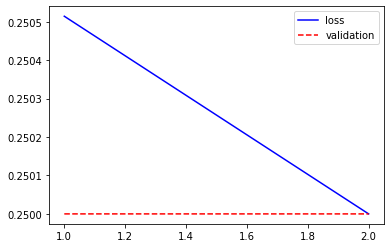

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 5)         130       
_________________________________________________________________
re_lu (ReLU)                 (None, 24, 24, 5)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 5)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 8)           1008      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 10)          330   

In [6]:
model = get_keras_model(dataset_shapes)
test_model(model, tr_d, ts_d)
model.summary()

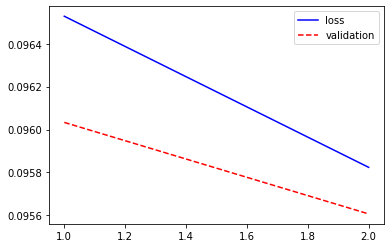

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
v_input_conv (VInputConv)    (None, 26, 24, 24, 5)     130       
_________________________________________________________________
v_conv (VConv)               (None, 16, 6, 6, 5)       0         
_________________________________________________________________
v_conv_1 (VConv)             (None, 126, 2, 2, 8)      1008      
_________________________________________________________________
v_conv_2 (VConv)             (None, 33, 1, 1, 10)      330       
_________________________________________________________________
v_output_conv (VOutputConv)  (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0   

In [7]:
model = get_simple_vector_model(dataset_shapes)
test_model(model, tr_d, ts_d)
model.summary()

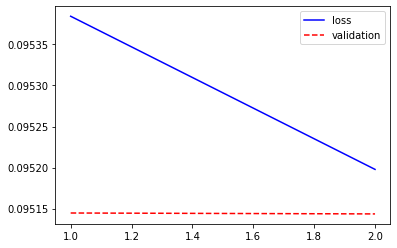

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
v_input_conv_2 (VInputConv)  (None, 26, 24, 24, 5)     130       
_________________________________________________________________
v_conv_fractal_2 (VConvFract (None, 16, 6, 6, 5)       100       
_________________________________________________________________
v_conv_4 (VConv)             (None, 126, 2, 2, 8)      1008      
_________________________________________________________________
v_conv_fractal_3 (VConvFract (None, 33, 1, 1, 10)      681       
_________________________________________________________________
v_output_conv_2 (VOutputConv (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10)                0   

In [10]:
model = get_fractal_vector_model(dataset_shapes)
test_model(model, tr_d, ts_d)
model.summary()